In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from collections import Counter


# Prepare Data

In [7]:
# ############################################
# STEP 1: Load data
# just load data and merge in one dataframe
# ############################################

dir_name = ""
anime = pd.read_csv(f"{dir_name}anime.csv")
rating = pd.read_csv(f"{dir_name}rating.csv")
data = pd.merge(rating, anime, on='anime_id')
data.rename(columns={'rating_x': 'user_rating', 'rating_y': 'anime_rating'}, inplace=True)

# free memory remove anime and rating
del anime
del rating

# ############################################
# STEP 2: Data cleaning
# ############################################

#   a)Remove data with missing values
#   b)Remove data with user_rating = -1 if we have a -1 it means that the user has watched the anime
#     but has not rated it so we does not have any information
#   c)Remove users with less than 10 ratings, they have not a lot of data so we can't extract good information
#     and also they increase the dimenionality of the data so:  no information more big matrix is bad

data.dropna(inplace=True)
data = data[data['user_rating'] != -1]
data = data.groupby('user_id').filter(lambda x: len(x) >= 10)


# ############################################
# STEP 3: Normalize user ratings
# all users are different so we normalize the ratings of the users to have a common scale
# idea is to have a scale from -1 to 1 where -1 is correspondent to 0 and 1 is the best rating for the user
# NOTE: we need to use not 0 for mean or in futur is counted as a missing value (we use 0 to fill pivot table)
# ############################################

# a) we compute mean and max rating for each user
# b) we normalize the rating of the user with the formula:

user_stats = data.groupby('user_id')['user_rating'].agg(['mean', 'max']).rename(columns={'mean': 'mean_rating', 'max': 'max_rating'})
data = data.merge(user_stats, on='user_id')

def normalize_rating(row):
    if row['user_rating'] < row['mean_rating']:
        if row['mean_rating'] == 0:
            return -1
        if -1 * (row['mean_rating'] - row['user_rating']) / row['mean_rating'] > 0 :
            print("ERROR")
        return -1 * (row['mean_rating'] - row['user_rating']) / row['mean_rating']
    else:
        if row['max_rating'] == row['mean_rating']: 
            return 0.01 
        return (row['user_rating'] - row['mean_rating']) / (row['max_rating'] - row['mean_rating'])

data['importance'] = data.apply(normalize_rating, axis=1)

# remove useless columns so we manage better the memory
data.drop(columns=['anime_rating', 'members', 'type', 'max_rating', 'mean_rating'], inplace=True)

data.head()



,user_id,anime_id,user_rating,name,genre,episodes,importance
0,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",220,0.178571
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",12,-0.206897
2,3,9919,8,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural",25,0.178571
3,3,11737,7,Ao no Exorcist Movie,"Action, Demons, Fantasy, Shounen, Supernatural",1,-0.074713
4,3,11757,9,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",25,0.589286


# Build model

In [8]:
# ############################################
# STEP 1: Split data
# ############################################

# We choose a 5% of the users as test users because we prefer use more information for the training

# First things we need to pivot the data to have a matrix with users as rows and anime as columns
# after we get 5% of the users as test users

user_anime_matrix = data.pivot_table(index='user_id', columns='anime_id', values='importance').fillna(0)
user_id_test = user_anime_matrix.sample(frac=0.05, random_state=42).index

print("Total users:", len(user_anime_matrix), "      Test users:", len(user_id_test) )

# ############################################
# STEP 2: Compute anime-anime similarity matrix
# ############################################

# Idea: we will find similarity between anime based on the importance (normalized rating ) of the users
# we use only user that rated an anime with importance > 0.5 (NOTE: importance is normalized rating so 0.5 is a good rating)
# with this raccomender system we will compute not only the similarity but also the popolarity of the anime
# Normally if you like an anime you will watch also similar anime but a similar good and normally a good is given by popularity (a bad anime is not popular)
# We also remove at the end the diagonal of the matrix because we don't want to have similarity with itself useless reccomand a anime to watch the same anime :)
# we also compute the vote count for each anime in case we need it

high_importance_threshold = 0.5
anime_anime_matrix = pd.DataFrame(0.0, index=user_anime_matrix.columns, columns=user_anime_matrix.columns, dtype=float)
anime_vote_count_matrix = pd.DataFrame(0, index=user_anime_matrix.columns, columns=user_anime_matrix.columns, dtype=int)

# progress bar just for us (to understand how much time we need to compute the matrix) more easy to wait if we know how much time we need :)
total_to_compute = len(user_anime_matrix.columns)
pbar = tqdm(total=total_to_compute, desc="Processing Anime")

# for each anime we compute 
# first we get the users that rated the anime with importance > 0.5
# then we sum the importance of the users that rated the anime
# we also count the number of votes for the anime
# we store the sum of the importance and the vote count in the matrix

for anime_id in user_anime_matrix.columns:
    high_importance_users = user_anime_matrix[(user_anime_matrix[anime_id] > high_importance_threshold) & (~user_anime_matrix.index.isin(user_id_test))]

    anime_vectors_sum = high_importance_users.sum(axis=0)
    anime_anime_matrix.loc[anime_id] = anime_vectors_sum
    
    anime_vote_counts = high_importance_users.astype(bool).sum(axis=0)
    anime_vote_count_matrix.loc[anime_id] = anime_vote_counts

    pbar.update(1)

pbar.close()

# last step we remove the diagonal of the matrix because we don't want to have similarity with itself
np.fill_diagonal(anime_anime_matrix.values, 0)
np.fill_diagonal(anime_vote_count_matrix.values, 0)

# in caso to speedup the computation we can save the matrix in a file and load it when we need it
anime_anime_matrix.to_csv(f"{dir_name}anime_anime_matrix.csv")

Total users: 55118       Test users: 2756


Processing Anime:   0%|          | 0/9891 [00:00<?, ?it/s]

# Testing

### testing 1: check how good is raccomandation respect single anime
we will check how good is with a popular anime like Hunte x Hunter and we will also check with a niche anime

Anime name of most 10 similar animes to animeHunter x Hunter: Greed Island
1         Fullmetal Alchemist: Brotherhood
6                   Hunter x Hunter (2011)
13      Code Geass: Hangyaku no Lelouch R2
19         Code Geass: Hangyaku no Lelouch
40                              Death Note
112                        Hunter x Hunter
145                    Hunter x Hunter OVA
146    Hunter x Hunter: Greed Island Final
Name: name, dtype: object
Number of users that have seen the anime: 485
Mean rating of the users: 9.61921965317919


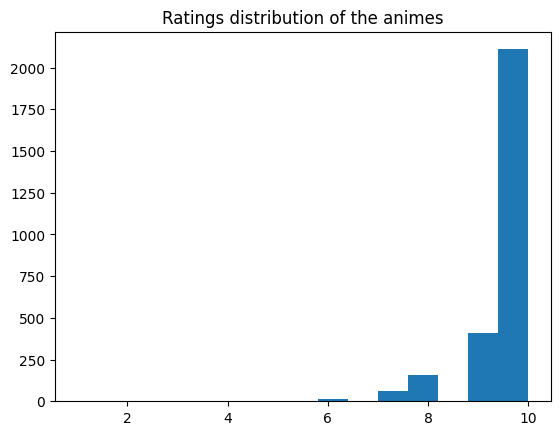

Anime name of most 10 similar animes to animeKaiba
15                      Sen to Chihiro no Kamikakushi
22                                       Cowboy Bebop
24                                      Mononoke Hime
28                                           Mushishi
29                         Tengen Toppa Gurren Lagann
84                                           Baccano!
130    Neon Genesis Evangelion: The End of Evangelion
211                           Neon Genesis Evangelion
Name: name, dtype: object
Number of users that have seen the anime: 179
Mean rating of the users: 8.840277777777779


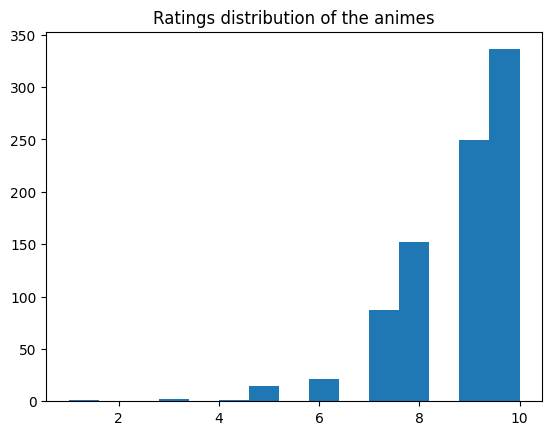

In [10]:
# the test function work as follow:
#   thest function give a feedback how person that love the anime love also the similar anime (predicted by us)
#   a) we get the similarity of the anime with the anime_id
#   b) we get the most similar 8 anime to the anime_id
#   c) we get the users that have loved the anime so with a very high importance
#   d) now we can check the mean rating of the users on the similar anime (only if the user has rated the anime)

# load anime just for plot 
anime = pd.read_csv(f"{dir_name}anime.csv")

def test_single_anime(anime_id, number_of_anime=8):
    similarities = anime_anime_matrix.loc[anime_id]
    most_similar_animes = similarities.sort_values(ascending=False).drop(index=anime_id)

    print("Anime name of most 10 similar animes to anime" + anime[anime['anime_id'] == anime_id]['name'].values[0])
    print(anime[anime['anime_id'].isin(most_similar_animes.head(number_of_anime).index)]['name'])

    users = user_anime_matrix[user_anime_matrix[anime_id] > 0.9].index
    print(f"Number of users that have seen the anime: {len(users)}")
    anime_ids = most_similar_animes.head(number_of_anime).index
    mean_importance = 0
    counter = 0
    ratings = []
    importance = []
    for user in users:
        for anime_id in anime_ids:
            if user_anime_matrix.loc[user, anime_id] != 0:
                mean_importance += user_anime_matrix.loc[user, anime_id]
                ratings.append(data[(data['user_id'] == user) & (data['anime_id'] == anime_id)]['user_rating'].values[0])
                importance.append(anime_anime_matrix.loc[813, anime_id])
                counter += 1

    print(f"Mean rating of the users: {np.mean(ratings)}")

    plt.hist(ratings, bins=15)
    plt.title("Ratings distribution of the animes")
    plt.show()


# one of the most famous anime hunter x hunter
anime_id = 138
test_single_anime(anime_id)

# a specific anime loved only by a few users is Kaiba from maasaky yuasa
anime_id = 3701
test_single_anime(anime_id)





### Test on Users
Now we will check how good is on test users

In [11]:

# ############################################
# STEP 1: Recommend top K animes
# ############################################

# we need a function that recommend the top K animes based on the input list of animes
# how it works:
#   a) for each anime in the input list we get the X most similar animes
#   b) we count the number of times that an anime is in the X most similar animes
#   c) we remove the input list from the recommendation
#   d) we get the top K animes that are recommended
#   e) we return the top K animes

NUMBER_OF_PREDICTIONS = 10

def recommend_top_animes(anime_list, X=15, K=NUMBER_OF_PREDICTIONS, similarity_matrix=anime_anime_matrix):
    recommendation_counts = Counter()

    for anime_id in anime_list:
        if anime_id in similarity_matrix.index:
            most_similar = similarity_matrix.loc[anime_id].drop(index=anime_id).nlargest(X).index.tolist()
            recommendation_counts.update(most_similar)

    for anime_id in anime_list:
        recommendation_counts.pop(anime_id, None)
    
    top_recommended_animes = [anime for anime, _ in recommendation_counts.most_common(K)]
    
    return top_recommended_animes



# ############################################
# STEP 2: Test the recommendation system
# ############################################
# in this part we just iterate on users, we get the top NUMBER_OF_ANIME animes that the user has seen
# we recommend the top animes to the user similiar to the animes that the user has seen
# we compute the mean rating of the user on the recommended animes if the user has rated the anime

GOOD_ANIME = 8
NUMBER_OF_ANIME = 10
total_rating_1 = 0
counter_1 = 0

pbar = tqdm(total=len(user_id_test), desc="Processing Test Users")

total_good = 0
total_bad = 0

for user_id in user_id_test:

    # get the top NUMBER_OF_ANIME animes that the user has seen
    anime_list = user_anime_matrix.loc[user_id].nlargest(NUMBER_OF_ANIME).index.tolist()
    top_animes_recommended = recommend_top_animes(anime_list)

    # compute the mean rating of the user on the recommended animes if the user has rated the anime
    total_rating_2 = 0
    counter_2 = 0
    for user in [user_id]:
        for anime_id in top_animes_recommended:
            if user_anime_matrix.loc[user, anime_id] != 0:
                rating = data[(data['user_id'] == user) & (data['anime_id'] == anime_id)]['user_rating'].values[0]
                total_rating_2 += rating
                
                if rating >= GOOD_ANIME:
                    total_good += 1
                else:
                    total_bad += 1
                counter_2 += 1


    pbar.update(1)

    if counter_2 == 0:
        continue
    
    total_rating_1 += total_rating_2/counter_2
    counter_1 += 1


print(f"Mean rating for all test users: {total_rating_1 / counter_1}")
print(f"Good recommendation: {total_good} Bad recommendation: {total_bad}, good rate {total_good / (total_good + total_bad)}")


# ############################################
# STEP 3: Get data to understand how good is the recommendation system
# ############################################

# Statistics 1 : mean rating of test users (not included the top NUMBER_OF_ANIME animes because our model can't use, not because is bad but because are the data used to recommend)

def mean_user_test(user_id, X):
    excluded_animes = user_anime_matrix.loc[user_id].nlargest(X).index.tolist()
    user_ratings = data[data['user_id'] == user_id]
    filtered_ratings = user_ratings[~user_ratings['anime_id'].isin(excluded_animes)]
    
    mean_rating = filtered_ratings['user_rating'].mean()
    
    return mean_rating


mean = 0
counter = 0
for user_id in user_id_test:
    mean_tmp = mean_user_test(user_id, NUMBER_OF_ANIME)
    if not np.isnan(mean_tmp):
        mean += mean_tmp
        counter += 1

print(f"Mean vote of test users: {mean / counter}")

# find total number of rating > 8 and rating < 8 to estimate hit rate of random recommendation
total_good = 0
total_bad = 0
for user_id in user_id_test:
    user_ratings = data[data['user_id'] == user_id]
    for rating in user_ratings['user_rating']:
        if rating >= GOOD_ANIME:
            total_good += 1
        else:
            total_bad += 1

print(f"RANDOM MODEL Good recommendation: {total_good} Bad recommendation: {total_bad}, good rate {total_good / (total_good + total_bad)}")


# Statistics 2 : mean if our model is powerful and predict perfect anime for users
# for every user we assume we predict the next 


def top_algoritm_comparison(user_id, X, Y):

    total_good = 0
    total_bad = 0

    user_ratings = data[data['user_id'] == user_id]
    sorted_ratings = user_ratings.sort_values(by='user_rating', ascending=False)
    excluded_top_x = sorted_ratings.iloc[X:]

    
    next_best_x = excluded_top_x.head(Y)

    for rating in next_best_x['user_rating']:
        if rating >= GOOD_ANIME:
            total_good += 1
        else:
            total_bad += 1
    
    improved_mean_rating = next_best_x['user_rating'].mean()
    
    return improved_mean_rating, total_good, total_bad


total_good = 0
total_bad = 0

mean = 0
counter = 0
for user_id in user_id_test:
    mean_tmp, good_tmo, bad_tmp = top_algoritm_comparison(user_id, NUMBER_OF_ANIME, NUMBER_OF_PREDICTIONS)
    if not np.isnan(mean_tmp):
        mean += mean_tmp
        counter += 1
        total_good += good_tmo
        total_bad += bad_tmp

print(f"Perfect result on test users: {mean / counter}")
print(f"Perfect recommendation: {total_good} Bad recommendation: {total_bad}, good rate {total_good / (total_good + total_bad)}")


# statistics 3: use a powerful and "cheat" model. This model predict only the top anime for the user and the other useless so mean is the best possible but not a good reccomandation
# the algoritm exclude the top X animes and predict the next best X animes



def top_algoritm_comparison2(user_id, X):
    total_bad = 0
    total_good = 0
    user_ratings = data[data['user_id'] == user_id]
    sorted_ratings = user_ratings.sort_values(by='user_rating', ascending=False)
    excluded_top_x = sorted_ratings.iloc[X:]
    next_best_x = excluded_top_x.head(1)
    for rating in next_best_x['user_rating']:
        if rating >= GOOD_ANIME:
            total_good += 1
        else:
            total_bad += 1
    improved_mean_rating = next_best_x['user_rating'].mean()
    return improved_mean_rating, total_good, total_bad

mean = 0
counter = 0

total_good = 0
total_bad = 0

for user_id in user_id_test:
    mean_tmp, good_tmo, bad_tmp = top_algoritm_comparison2(user_id, NUMBER_OF_ANIME)
    if not np.isnan(mean_tmp):
        mean += mean_tmp
        counter += 1
        total_good += good_tmo
        total_bad += bad_tmp

print(f"Perfect cheat result on test users: {mean / counter}")
print(f"Perfect cheat recommendation: {total_good} Bad recommendation: {total_bad}, good rate {total_good / (total_good + total_bad)}")



Processing Test Users:   0%|          | 0/2756 [00:00<?, ?it/s]

Mean rating for all test users: 8.351257230218614
Good recommendation: 7229 Bad recommendation: 1666, good rate 0.8127037661607645
Mean vote of test users: 7.672621454095946
RANDOM MODEL Good recommendation: 189439 Bad recommendation: 128631, good rate 0.5955890212846229
Perfect result on test users: 8.835796498893055
Perfect recommendation: 23053 Bad recommendation: 2114, good rate 0.9160011125680455
Perfect cheat result on test users: 9.163522012578616
Perfect cheat recommendation: 2536 Bad recommendation: 167, good rate 0.9382167961524233
